<a href="https://colab.research.google.com/github/zalNeth/A.C.E.L.S._/blob/main/ACELS_V7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

### Import Dependencies

In [ ]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math 

# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import seaborn as sns



### Import Dataset

In [ ]:
# Mount Google Drive to acccess dataframe
from google.colab import drive 
drive.mount('/content/gdrive')

from google.colab import files
uploaded = files.upload()

Mounted at /content/gdrive


Saving ACELS_Dataset_float.csv to ACELS_Dataset_float.csv


In [ ]:
data = pd.read_csv('ACELS_Dataset_float.csv')

### Create X and Y data matricies

In [ ]:
data.head()

,s1,s2,s3,s4,s5,s6,s7,s8,x,y,z,roll,pitch
0,409.0,273.0,357.0,276.0,240.0,329.0,214.0,327.0,0.0,0.0,0.0,0.0,0.0
1,409.0,273.0,357.0,276.0,240.0,329.0,214.0,327.0,0.0,0.0,0.0,0.0,0.0
2,409.0,273.0,357.0,276.0,240.0,329.0,214.0,327.0,0.0,0.0,0.0,0.0,0.0
3,409.0,273.0,357.0,276.0,240.0,329.0,214.0,327.0,0.0,0.0,0.0,0.0,0.0
4,409.0,273.0,357.0,276.0,240.0,329.0,214.0,327.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

data.head()
data.dtypes

s1       float64
s2       float64
s3       float64
s4       float64
s5       float64
s6       float64
s7       float64
s8       float64
x        float64
y        float64
z        float64
roll     float64
pitch    float64
dtype: object

In [ ]:
data32 = data.astype(np.float32)
data32.dtypes

s1       float32
s2       float32
s3       float32
s4       float32
s5       float32
s6       float32
s7       float32
s8       float32
x        float32
y        float32
z        float32
roll     float32
pitch    float32
dtype: object

In [ ]:
train_stats = data32.describe()
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
s1,13835.0,431.568329,75.837227,170.0,383.0,451.0,487.0,547.0
s2,13835.0,352.713837,72.866318,175.0,298.0,360.0,419.0,478.0
s3,13835.0,402.710724,77.235115,164.0,348.0,419.0,460.0,528.0
s4,13835.0,350.783173,79.197685,155.0,290.0,357.0,415.0,493.0
s5,13835.0,331.181427,76.769592,154.0,264.0,342.0,399.0,477.0
s6,13835.0,379.517822,80.937508,154.0,332.0,391.0,443.0,525.0
s7,13835.0,314.792633,74.028397,150.0,254.0,321.0,375.0,457.0
s8,13835.0,378.571075,88.135742,135.0,331.0,393.0,449.0,529.0
x,13835.0,-0.167329,8.387443,-20.0,-10.0,0.0,10.0,20.0
y,13835.0,-0.149982,8.410809,-20.0,-10.0,0.0,10.0,20.0


In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data32)

normed_data.head()

,s1,s2,s3,s4,s5,s6,s7,s8,x,y,z,roll,pitch
0,-2.631535,-1.944847,0.172063,-2.055403,0.570780,-0.500606,0.435068,1.196211,-1.172309,1.206778,-0.587341,-0.145177,0.024363
1,0.810046,-0.682261,-2.857647,1.227521,-1.943236,1.550359,1.178026,-0.551094,1.808338,1.206778,-0.587341,-0.145177,0.024363
2,-1.128316,-0.270548,0.456907,-0.338181,1.065768,0.339548,1.178026,1.105442,-1.172309,1.206778,0.556180,-1.805117,0.024363
3,1.007838,1.019486,0.314485,1.063375,-0.510377,0.549587,-0.456482,-1.572246,1.212209,-1.171114,-0.587341,1.514762,0.024363
4,-0.165728,-0.394062,-0.086887,-0.325555,-0.458273,-0.216436,-0.510515,-0.165325,0.019950,0.017832,-0.587341,1.514762,0.024363


In [ ]:
feature_data = normed_data[['s1','s2','s3','s4','s5','s6','s7','s8']]
target_data = normed_data[['x', 'y', 'z', 'roll','pitch']]

In [ ]:
feature_data.head()

,s1,s2,s3,s4,s5,s6,s7,s8
0,-2.631535,-1.944847,0.172063,-2.055403,0.570780,-0.500606,0.435068,1.196211
1,0.810046,-0.682261,-2.857647,1.227521,-1.943236,1.550359,1.178026,-0.551094
2,-1.128316,-0.270548,0.456907,-0.338181,1.065768,0.339548,1.178026,1.105442
3,1.007838,1.019486,0.314485,1.063375,-0.510377,0.549587,-0.456482,-1.572246
4,-0.165728,-0.394062,-0.086887,-0.325555,-0.458273,-0.216436,-0.510515,-0.165325


In [ ]:
target_data.tail()

,x,y,z,roll,pitch
13830,1.212209,0.017832,0.556180,1.514762,-1.749662
13831,-1.172309,0.017832,0.556180,-0.145177,0.024363
13832,0.019950,-1.171114,2.843223,1.514762,0.024363
13833,1.212209,1.206778,-0.587341,-1.805117,-1.749662
13834,-1.172309,-1.171114,-0.587341,0.684792,0.911376


In [ ]:
x = feature_data
y = target_data

In [ ]:
x.shape, y.shape

((13835, 8), (13835, 5))

### Splitting the Data

In [ ]:
#from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
#X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()


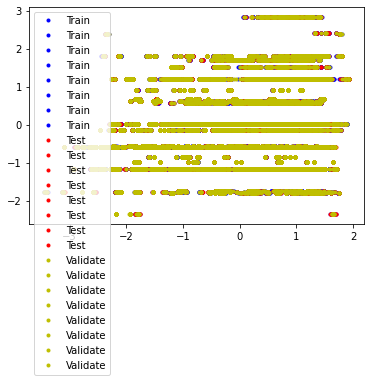

,x,y,z,roll,pitch
0,-1.172309,1.206778,-0.587341,-0.145177,0.024363
1,1.808338,1.206778,-0.587341,-0.145177,0.024363
2,-1.172309,1.206778,0.556180,-1.805117,0.024363
3,1.212209,-1.171114,-0.587341,1.514762,0.024363
4,0.019950,0.017832,-0.587341,1.514762,0.024363


In [ ]:
TRAIN_SPLIT = int(0.6 * 13834)
TEST_SPLIT = int(0.2 * 13834 + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(x, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y, [TRAIN_SPLIT, TEST_SPLIT])

#assert (x_train.size + x_validate.size + x_test.size) ==  13834

plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

x_train.head()
y_train.head()

### Building the Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model = linear_model.LinearRegression()

In [ ]:
model = tf.keras.Sequential()
model.add(keras.layers.Dense(60, activation='relu', input_shape=(8,)))
model.add(keras.layers.Dense(80, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(5))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                540       
_________________________________________________________________
dense_1 (Dense)              (None, 80)                4880      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8100      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 305       
Total params: 19,885
Trainable params: 19,885
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_1 = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_validate, y_validate))

Epoch 1/500
260/260 [==============================] - 2s 4ms/step - loss: 0.5172 - mae: 0.4505 - val_loss: 0.4470 - val_mae: 0.4216
Epoch 2/500
260/260 [==============================] - 1s 2ms/step - loss: 0.4180 - mae: 0.3772 - val_loss: 0.3800 - val_mae: 0.3693
Epoch 3/500
260/260 [==============================] - 1s 2ms/step - loss: 0.3610 - mae: 0.3596 - val_loss: 0.3513 - val_mae: 0.3577
Epoch 4/500
260/260 [==============================] - 1s 2ms/step - loss: 0.3128 - mae: 0.3353 - val_loss: 0.2759 - val_mae: 0.3076
Epoch 5/500
260/260 [==============================] - 1s 2ms/step - loss: 0.2717 - mae: 0.3066 - val_loss: 0.2389 - val_mae: 0.2798
Epoch 6/500
260/260 [==============================] - 1s 2ms/step - loss: 0.2536 - mae: 0.2943 - val_loss: 0.2512 - val_mae: 0.3014
Epoch 7/500
260/260 [==============================] - 1s 2ms/step - loss: 0.2323 - mae: 0.2769 - val_loss: 0.2563 - val_mae: 0.3030
Epoch 8/500
260/260 [==============================] - 1s 2ms/step - 

In [ ]:
# Save model to disk
model.save(MODEL_TF)

size_tf = os.path.getsize(MODEL_TF)
pd.DataFrame.from_records([["Tensorflow", f"{size_tf} bytes",""]], columns = ["Model", "Size", ""], index="Model")

INFO:tensorflow:Assets written to: models/model/assets


,Size,
Model,,
Tensorflow,4096 bytes,


## Plot Metrics

1. Mean Squared Error

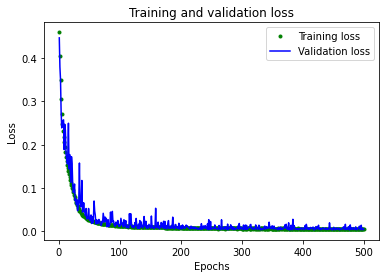

In [ ]:
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

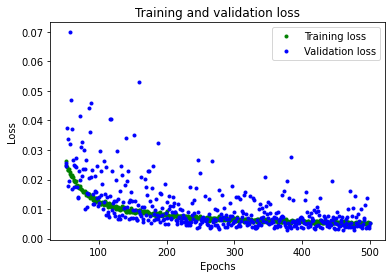

In [ ]:
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. Mean Absolute Error

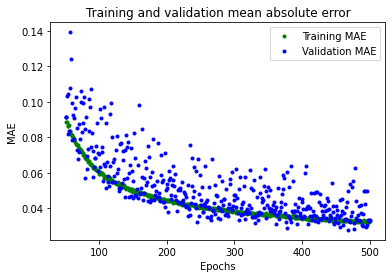

In [ ]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

87/87 [==============================] - 0s 1ms/step - loss: 0.0049 - mae: 0.0334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()


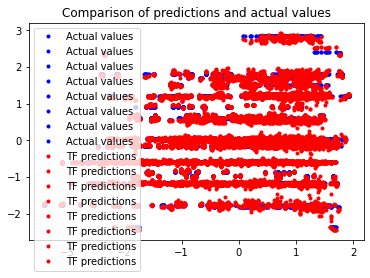

array([[ 1.2910532 ,  1.740644  , -0.6115061 , -0.13354567,  0.0033299 ],
       [ 1.193986  ,  1.1648059 ,  1.608301  , -1.833139  ,  0.14883602],
       [ 0.63253295, -0.03719372, -0.58188987, -0.13066712,  0.9538459 ],
       ...,
       [ 0.04072486, -1.189733  ,  0.5544836 ,  1.4637334 ,  1.8731172 ],
       [-1.7746327 ,  0.59229493, -0.5843798 , -0.17615888,  0.00971728],
       [ 1.2594134 ,  1.1498896 , -0.59823895,  0.7073331 ,  0.0444879 ]],
      dtype=float32)

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

y_test_pred

In [ ]:
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} mm'.format(test_mae))



Testing set Mean Abs Error:  0.03 mm


## Denormalize output 

In [ ]:
pred_df = pd.DataFrame(y_test_pred, columns = ['x','y','z','roll','pitch'])
pred_df.head()

,x,y,z,roll,pitch
0,1.291053,1.740644,-0.611506,-0.133546,0.003330
1,1.193986,1.164806,1.608301,-1.833139,0.148836
2,0.632533,-0.037194,-0.581890,-0.130667,0.953846
3,-1.747328,-1.794092,-0.603704,-0.176795,0.033681
4,0.035992,1.188960,-0.622477,-1.867178,1.757349


In [ ]:
def denorm(x):
  return (x * train_stats['std']) + train_stats['mean']

denormed_data = denorm(pred_df)

denormed_data.head(15)

,pitch,roll,s1,s2,s3,s4,s5,s6,s7,s8,x,y,z
0,-0.118563,0.070072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.661305,14.490241,-0.105661
1,0.701641,-10.168815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.847160,9.646977,9.600354
2,5.239400,0.087413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.138005,-0.462811,0.023835
3,0.052522,-0.190476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.822941,-15.239750,-0.071544
4,9.768663,-10.373878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134552,9.850133,-0.153629
5,0.220975,0.106956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.723053,9.706179,-0.036064
6,0.019031,5.057756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.418299,4.640898,0.005478
7,-9.516230,-9.892406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010998,-10.189644,4.932810
8,-0.127742,-5.306013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.021047,-10.181056,-0.107478
9,-0.630400,-0.308944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.229106,-1.664212,14.496959


### Generate aTensorflow Lite Model

In [ ]:
x_train.iloc[[1]]

,s1,s2,s3,s4,s5,s6,s7,s8
1,0.810046,-0.682261,-2.857647,1.227521,-1.943236,1.550359,1.178026,-0.551094


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for _ in range(500):
    yield([x_train.astype(np.float32)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

23736

In [ ]:
size_tf_small = os.path.getsize(MODEL_NO_QUANT_TFLITE)
pd.DataFrame.from_records([["Tensorflow", f"{size_tf_small} bytes",""]], columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
Tensorflow,81620 bytes,


### Compare Quantized and Non Quantized Model

In [ ]:
from pandas import DataFrame
x_test_np = DataFrame.to_numpy(x_test)
#x_test_np = x_test_np.astype('object')
x_test_np[1]

len(x_test_np)

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [ ]:
# Compare size
pd.DataFrame.from_records(
    [
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

### Generate TF Lite for Microc Model

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

### Generate C file for No quantized model

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}